In [6]:
# we need to install some libraries as they are not default on the system
# pip install geodatasets cartopy

import geopandas
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from geodatasets import get_path

<Axes: >

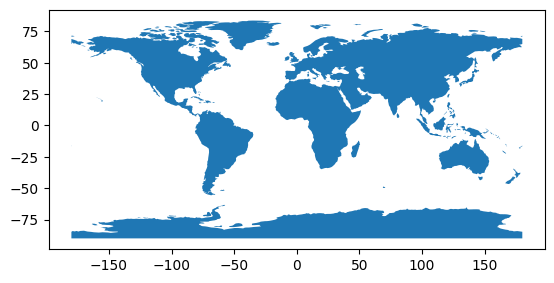

In [7]:
# let's get our basic earth data

path = get_path("naturalearth.land")
world = geopandas.read_file(path)

# and test our libraries loaded

world.plot()

<GeoAxes: title={'center': 'EPSG:3857'}>

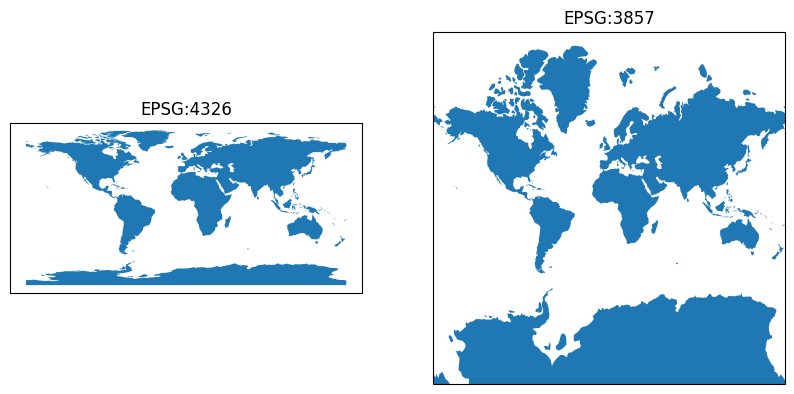

In [8]:
# (left-side) EPSG:4326 - WGS 84, latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System among others.
# (right side) EPSG:3857 - Web Mercator projection used for display by many web-based mapping tools, including Google Maps and OpenStreetMap.
crs = ccrs.epsg("3857")
world_epsg = world.to_crs(epsg="3857")

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": crs}, figsize=(10, 5))
axs[0].set(title='EPSG:4326')
axs[1].set(title='EPSG:3857')
world.plot(ax=axs[0])
world_epsg.plot(ax=axs[1])

In [9]:
import pandas as pd
df = pd.read_csv('https://firms.modaps.eosdis.nasa.gov/content/notebooks/sample_viirs_snpp_071223.csv')

# show top 5 records
df.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight
0,0.05836,29.59085,295.64,0.38,0.59,2023-07-12,3,N,VIIRS,n,2.0NRT,275.15,0.83,N
1,0.48765,31.50760,296.73,0.51,0.66,2023-07-12,3,N,VIIRS,n,2.0NRT,275.15,0.56,N
2,2.15227,13.94524,305.26,0.51,0.49,2023-07-12,3,N,VIIRS,n,2.0NRT,287.94,1.08,N
3,2.15681,13.94618,319.05,0.51,0.49,2023-07-12,3,N,VIIRS,n,2.0NRT,288.77,1.81,N
4,2.15754,13.94131,301.13,0.51,0.50,2023-07-12,3,N,VIIRS,n,2.0NRT,288.17,1.81,N


In [10]:
# now convert latitude, longitude values into point geometry

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# show top 3 records
gdf.head(3)

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,geometry
0,0.05836,29.59085,295.64,0.38,0.59,2023-07-12,3,N,VIIRS,n,2.0NRT,275.15,0.83,N,POINT (29.59085 0.05836)
1,0.48765,31.50760,296.73,0.51,0.66,2023-07-12,3,N,VIIRS,n,2.0NRT,275.15,0.56,N,POINT (31.5076 0.48765)
2,2.15227,13.94524,305.26,0.51,0.49,2023-07-12,3,N,VIIRS,n,2.0NRT,287.94,1.08,N,POINT (13.94524 2.15227)


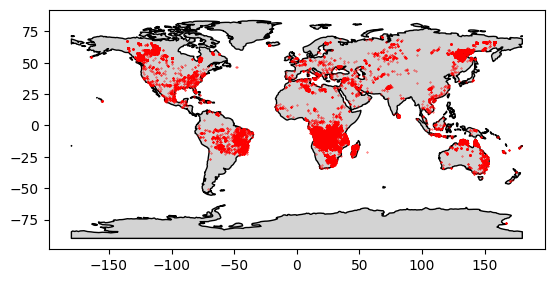

In [11]:
# optional: set outline and fill colors
ax = world.plot(color="lightgrey", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red", markersize=0.1)

plt.show()

<Axes: title={'center': 'Brazil wildfires July, 2023'}>

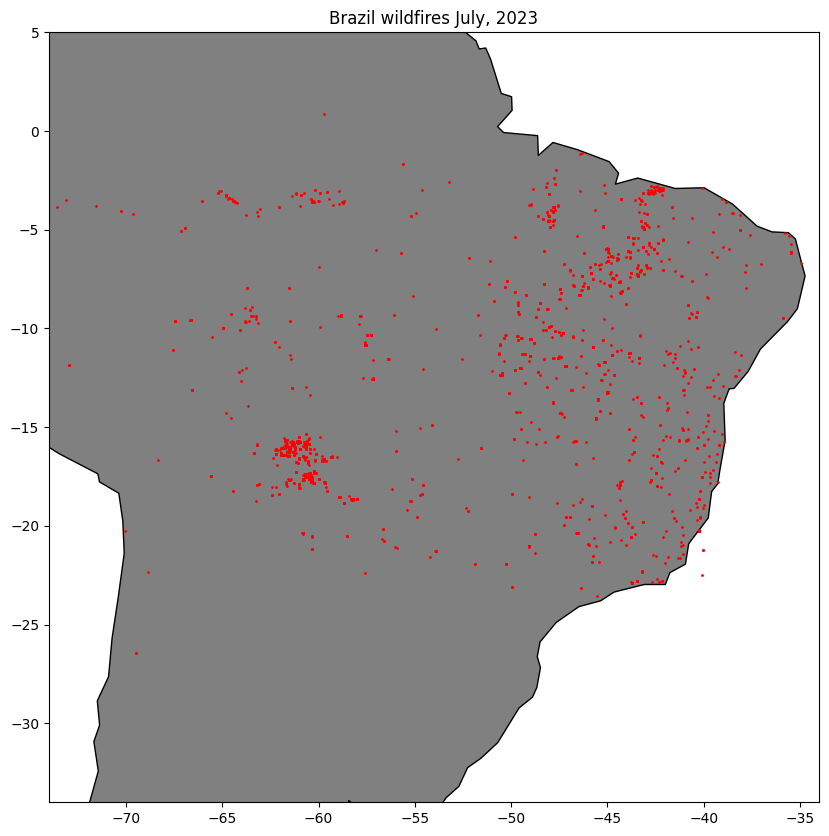

In [12]:
# create Brazil subset

# the latitude and longitude bounds for Brazil
df_brazil = df[(df['longitude'] >= -74) & (df['latitude'] >= -34) & (df['longitude'] <= -34) & (df['latitude'] <= 5)].copy()

# create geometry for points using latitude and longitude and specifying projection as EPSG:4326

# Create geometry for points using latitude and longitude and specifying projection as EPSG:4326
gdf = geopandas.GeoDataFrame(df_brazil, geometry=geopandas.points_from_xy(df_brazil.longitude, df_brazil.latitude), crs="EPSG:4326")

# Set the extent for Brazil
extent = [-74, -34, -34, 5]
ax = world.plot(figsize=(10, 10), color="grey", edgecolor="black")
ax.set_xlim([extent[0], extent[2]])
ax.set_ylim([extent[1], extent[3]])

ax.set(title='Brazil wildfires July, 2023')

# Plot the GeoDataFrame
gdf.plot(ax=ax, color="red", markersize=1)


In [13]:
# convert aqc_date and aqc_time to acq_datetime as datetime object
df_brazil['acq_datetime'] = pd.to_datetime(df_brazil['acq_date'] + ' ' + df_brazil['acq_time'].astype(str).str.zfill(4), format='%Y-%m-%d %H%M')
gdf = geopandas.GeoDataFrame(df_brazil, geometry=geopandas.points_from_xy(df_brazil.longitude, df_brazil.latitude), crs="EPSG:4326")

## find maximum time from our dataset since we are pretending current date time is July 12 2023, 19:50(7:50pm) GMT.
# if the data were recent, we would set dt_max = pd.Timestamp.now();
dt_max = pd.Timestamp("2023-07-12 19:50:00")

# create our subsets for 4 color classes

# less than or equal to 1 hour; gdf1 <= 1hour
gdf1 = gdf[gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=1))]

# greater than 1 hour but less than or equal to 4 hours; gdf2 > 1 hour and gdf2 <= 4 hours
gdf2 = gdf[(gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=4))) & 
           (gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=1)))]

# greater than 4 hours but less than or equal to 12 hours; gdf3 > 4 hours and gdf2 <= 12 hours
gdf3 = gdf[(gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=12))) & 
           (gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=4)))]

# greater than 12 hours; gdf4 > 12 hours
gdf4 = gdf[gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=12))]

# now let's make sure the sizes are correct. They should all add up to 2230
print('Sizes %i, %i, %i, %i from total of %i' % (gdf1.count()[0], gdf2.count()[0], gdf3.count()[0], gdf4.count()[0], gdf.count()[0]))

Sizes 0, 993, 0, 1237 from total of 2230


/var/folders/34/gby6tkr103xfh0fy_017m5grcjxgrv/T/ipykernel_8700/1659117223.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Sizes %i, %i, %i, %i from total of %i' % (gdf1.count()[0], gdf2.count()[0], gdf3.count()[0], gdf4.count()[0], gdf.count()[0]))
/var/folders/34/gby6tkr103xfh0fy_017m5grcjxgrv/T/ipykernel_8700/1659117223.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Sizes %i, %i, %i, %i from total of %i' % (gdf1.count()[0], gdf2.count()[0], gdf3.count()[0], gdf4.count()[0], gdf.count()[0]))
/var/folders/34/gby6tkr103xfh0fy_017m5grcjxgrv/T/ipykernel_8700/1659117223.py:26: FutureWarning: Ser

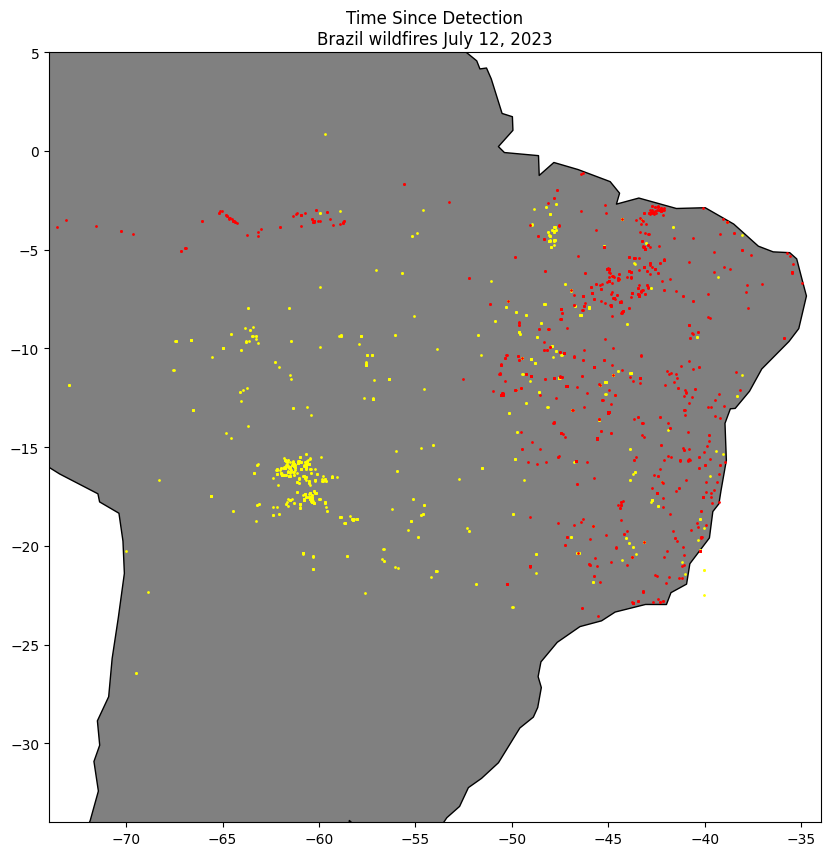

In [14]:
# set our extent to Brazil
extent = [-74, -34, -34, 5]
ax = world.plot(figsize=(10, 10), color="grey", edgecolor="black")

# set map extent
ax.set_xlim([extent[0], extent[2]])
ax.set_ylim([extent[1], extent[3]])

# add graph title
ax.set(title='Time Since Detection\nBrazil wildfires July 12, 2023')

# Color code each set; also we are drawing in opposite order, so the older detections are drawn first so the newer ones are on the top
if not gdf4.empty:
    gdf4.plot(ax=ax, color="yellow", markersize=1)
if not gdf3.empty:
    gdf3.plot(ax=ax, color="orange", markersize=1)
if not gdf2.empty:
    gdf2.plot(ax=ax, color="red", markersize=1)
if not gdf1.empty:
    gdf1.plot(ax=ax, color="darkred", markersize=1)

plt.show()

In [15]:
# add some more detailed information to our map so our viewers can better understand the location of these fire detection.
import contextily as cx
from pyproj import Transformer

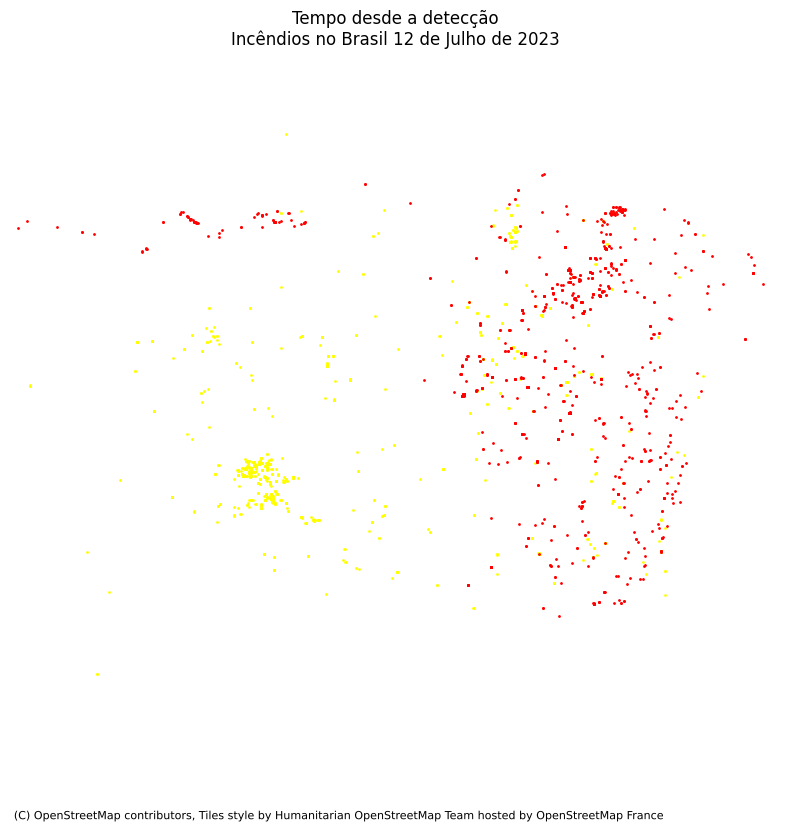

In [16]:

# Certifique-se de que os GeoDataFrames estão no CRS EPSG:4326
gdf = gdf.to_crs(epsg=4326)
gdf1 = gdf1.to_crs(epsg=4326)
gdf2 = gdf2.to_crs(epsg=4326)
gdf3 = gdf3.to_crs(epsg=4326)
gdf4 = gdf4.to_crs(epsg=4326)

# Defina a extensão do Brasil no CRS EPSG:4326
extent_4326 = [-74, -34, -34, 5]

# Crie uma figura e um eixo
fig, ax = plt.subplots(figsize=(10, 10))

# Adicione o basemap
cx.add_basemap(ax, crs="EPSG:4326", alpha=0.3, zoom=5)

# Ajuste a extensão do mapa para o CRS EPSG:4326
ax.set_xlim(extent_4326[0], extent_4326[2])
ax.set_ylim(extent_4326[1], extent_4326[3])

# Plote o mapa de base e adicione o título
ax.set(title='Tempo desde a detecção\nIncêndios no Brasil 12 de Julho de 2023')

# Desligue os rótulos dos eixos
ax.set_axis_off()

# Plote os dados de incêndios, com cores codificadas
if not gdf4.empty:
    gdf4.plot(ax=ax, color="yellow", markersize=1)
if not gdf3.empty:
    gdf3.plot(ax=ax, color="orange", markersize=1)
if not gdf2.empty:
    gdf2.plot(ax=ax, color="red", markersize=1)
if not gdf1.empty:
    gdf1.plot(ax=ax, color="darkred", markersize=1)

# Mostre o gráfico
plt.show()


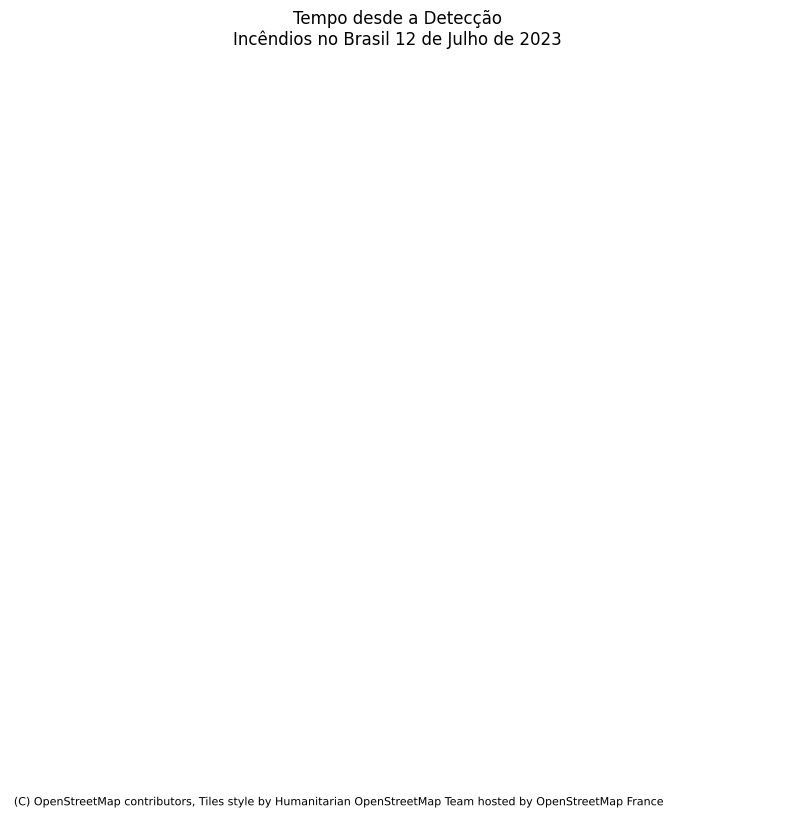

In [17]:
import contextily as cx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from geodatasets import get_path

# Carregue os dados de incêndio
df = pd.read_csv('https://firms.modaps.eosdis.nasa.gov/content/notebooks/sample_viirs_snpp_071223.csv')

# Crie o subset para o Brasil
df_brazil = df[(df['longitude'] >= -74) & (df['latitude'] >= -34) & (df['longitude'] <= -34) & (df['latitude'] <= 5)].copy()

# Converta as datas para datetime
df_brazil['acq_datetime'] = pd.to_datetime(df_brazil['acq_date'] + ' ' + df_brazil['acq_time'].astype(str).str.zfill(4), format='%Y-%m-%d %H%M')

# Crie um GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_brazil, geometry=gpd.points_from_xy(df_brazil.longitude, df_brazil.latitude), crs="EPSG:4326"
)

# Defina o máximo tempo de detecção
dt_max = gdf['acq_datetime'].max()

# Crie subsets baseados no tempo desde a detecção
gdf1 = gdf[gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=1))]
gdf2 = gdf[(gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=4))) & (gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=1)))]
gdf3 = gdf[(gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=12))) & (gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=4)))]
gdf4 = gdf[gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=12))]

# Defina o extent para o Brasil
extent = [-74, -34, -34, 5]

# Crie o plot
fig, ax = plt.subplots(figsize=(10, 10))

# Adicione o basemap
cx.add_basemap(ax, crs="EPSG:3857", alpha=0.3, zoom=5)

# Ajuste a extensão do plot para o CRS EPSG:3857
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

# Defina o título e desative os eixos
ax.set(title='Tempo desde a Detecção\nIncêndios no Brasil 12 de Julho de 2023')
ax.set_axis_off()

# Transforme os dados para EPSG:3857 e plote
gdf4.to_crs(epsg=3857).plot(ax=ax, color="yellow", markersize=1)
gdf3.to_crs(epsg=3857).plot(ax=ax, color="orange", markersize=1)
gdf2.to_crs(epsg=3857).plot(ax=ax, color="red", markersize=1)
gdf1.to_crs(epsg=3857).plot(ax=ax, color="darkred", markersize=1)

# Mostre o gráfico
plt.show()
